# 戦略・銘柄毎のシグナル判定（日足）

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import talib

In [2]:
# クロスオーバーとクロスアンダー関数
def crossover(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def crossoverthresh(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def crossunder(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

def crossunderthresh(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

In [3]:
# RedSword氏の戦略によるシグナル判定
def redsword(df,ema1Length=9,ema2Length=21,ema3Length=34,\
        rsiLength=14,rsiThreshold=50,\
        macdFastLength=12,macdSlowLength=26,macdSignalSmoothing=9):
    # create dataframe
    df1 = df.copy()
    # HLCC4 calculation
    df1['hlcc4_custom'] = (df1['high'] + df1['low'] + df1['close'] + df1['close']) / 4
    # Calculate EMA and RSI based on HLCC4
    df1["ema1"] = talib.EMA(df1["hlcc4_custom"], timeperiod=ema1Length)
    df1["ema2"] = talib.EMA(df1["hlcc4_custom"], timeperiod=ema2Length)
    df1["ema3"] = talib.EMA(df1["hlcc4_custom"], timeperiod=ema3Length)
    df1["rsi"] = talib.RSI(df1["hlcc4_custom"], timeperiod=rsiLength)
    # Calculate MACD Histogram
    df1["a"], df1["b"], df1["histogram"] = talib.MACD(df1["hlcc4_custom"],\
            fastperiod=macdFastLength, slowperiod=macdSlowLength, signalperiod=macdSignalSmoothing)
    # EMA1 and EMA2 crossover conditions
    df1['emaCrossUp'] = crossover(df1['ema1'], df1['ema2'])
    df1['emaCrossDown'] = crossunder(df1['ema1'], df1['ema2'])
    # BUY signal conditions
    df1['RS_buySignal'] = df1['emaCrossUp'] & (df1['hlcc4_custom'] > df1['ema3']) & \
        (df1['rsi'] > rsiThreshold) & (df1['close'] > df1['open']) & (df1['histogram'] > 0)
    # SELL signal conditions
    df1['RS_sellSignal'] = df1['emaCrossDown'] & (df1['hlcc4_custom'] < df1['ema3']) & \
        (df1['rsi'] < rsiThreshold) & (df1['close'] < df1['open']) & (df1['histogram'] < 0)
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','RS_buySignal','RS_sellSignal']]

In [4]:
# Kaabar氏の単純戦略によるシグナル判定
def kaabarsimple(df,rsiLength=14,rsiLowerThreshold=30,\
        rsiUpperThreshold=70,bollingerLength=20):
    # create dataframe
    df1 = df.copy()
    # calculate RSI
    df1["RSI"] = talib.RSI(df1["close"], timeperiod=rsiLength)
    # calculate Bollinger Bands
    df1["upperband"], df1["middleband"], df1["lowerband"] = talib.BBANDS(df1["close"], \
                        timeperiod=bollingerLength, nbdevup=2, nbdevdn=2, matype=0)
    # Bollinger crossover conditions
    df1['bollCrossUp'] = crossover(df1['close'], df1['lowerband'])
    df1['bollCrossDown'] = crossunder(df1['close'], df1['upperband'])
    # RSI crossover condition
    df1['rsiCrossUp'] = crossoverthresh(df1['RSI'], rsiLowerThreshold)
    df1['rsiCrossDown'] = crossunderthresh(df1['RSI'], rsiUpperThreshold)
    # BUY signal conditions
    df1['KB_buySignal'] = df1['rsiCrossUp'] & df1['bollCrossUp']
    # SELL signal conditions
    df1['KB_sellSignal'] = df1['rsiCrossDown'] & df1['bollCrossDown']
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','KB_buySignal','KB_sellSignal']]

In [5]:
# 評価する銘柄のリスト
list_ticker = ['4755.T','9983.T']
# 期間の指定
end_date = datetime.today()
start_date = end_date - timedelta(days=730)

In [6]:
# 各銘柄についてシグナル判定を行い結果を縦連結する
df0 = pd.DataFrame()
for symbol in list_ticker:
    # yahooサイトからデータをダウンロード
    data = yf.download(symbol, start_date, end_date)
    data['ticker'] = symbol
    df = data.reset_index().drop(columns='Close').rename(columns={'Date':'timestamp', 'Open':'open', \
            'High':'high', 'Low':'low', 'Adj Close':'close', 'Volume':'volume'})
    # RedSword氏の戦略によるシグナル判定の実施
    df_RedSword = redsword(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_RedSword, how="inner", on=['timestamp','ticker'])
    # Sofien Kaabar氏のsimple戦略によるシグナル判定の実施
    df_KaabarSimple = kaabarsimple(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_KaabarSimple, how="inner", on=['timestamp','ticker'])
    # 一銘柄のシグナル判定結果を元のデータに縦連結する
    df0 = pd.concat([df0,df],axis=0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


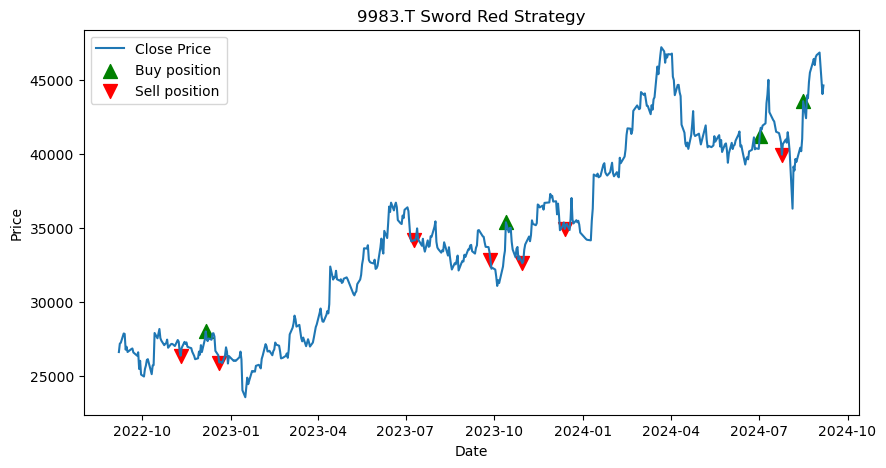

In [7]:
# 特定の銘柄のデータを取り出す
focus_ticker = '9983.T'
df = df0[df0['ticker'].str.contains(focus_ticker)]
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['RS_buySignal']], df['close'][df['RS_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['RS_sellSignal']], df['close'][df['RS_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' Sword Red Strategy')
# チャートの表示
plt.show()

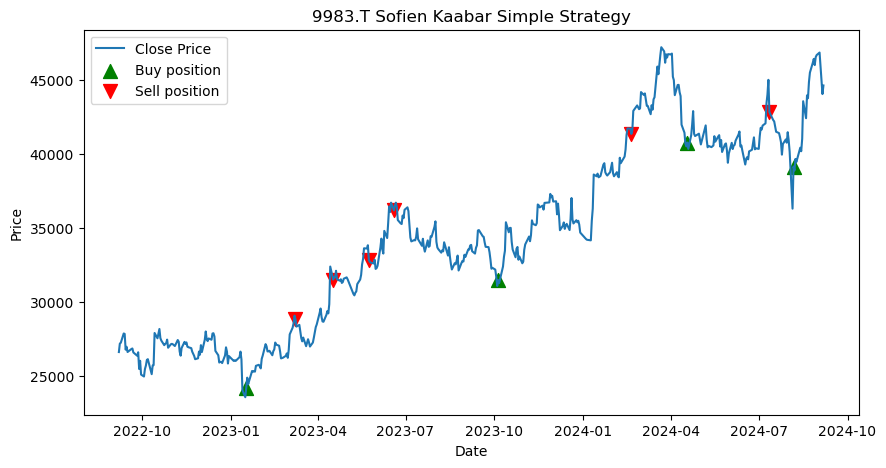

In [8]:
# 特定の銘柄のデータを取り出す
focus_ticker = '9983.T'
df = df0[df0['ticker'].str.contains(focus_ticker)]
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['KB_buySignal']], df['close'][df['KB_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['KB_sellSignal']], df['close'][df['KB_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' Sofien Kaabar Simple Strategy')
# チャートの表示
plt.show()